In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!pip install -q roboflow supervision
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install onnxruntime
#!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 864.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ydcpxusi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ydcpxusi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) .

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
workspace = '/content/gdrive/MyDrive/NutriFood'

Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.95,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=1500,  # Requires open-cv to run post-processing
)

In [ ]:
np.random.seed(4)
def show_anns(anns, idx=[0]):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    # ax = plt.gca()
    # ax.set_autoscale_on(False)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        # color_mask = np.concatenate([[255, 0, 0], [0.35]])
        img[m] = color_mask
    # ax.imshow(img)
    return img

In [ ]:
def show_mask(masks, idx=[0]):
  masks = [
    mask['segmentation']
    for mask
    in sorted(masks, key=lambda x: x['area'], reverse=True)
  ]
  mask = np.zeros(masks[0].shape)
  for id in idx:
    mask = np.logical_or(mask, masks[id])
  return mask

In [ ]:
# sort the detections by size
def show_detections(image, annotations):
  annotations = sorted(annotations, key=lambda x: x['area'], reverse=True)
  masks = []
  bboxes = []
  scale = (224 * 224) / (1024 * 1024)
  for annotation in annotations:
    if annotation['area'] > 20000 * scale and annotation['area'] < 100000 * scale:
      masks.append(annotation['segmentation'])
      bboxes.append(annotation['bbox'])
  ROIs = []
  # Draw the bounding boxes on the image
  for (x, y, w, h) in bboxes:
    # Extract the region of interest (ROI) from the image
    roi = image[y:y+h, x:x+w]
    resized_roi = cv2.resize(roi, (224, 224))
    resized_roi = cv2.cvtColor(resized_roi, cv2.COLOR_BGR2RGB)
    ROIs.append(resized_roi)
  for (x, y, w, h) in bboxes:
    # Draw bounding boxes on the images
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
  return image, bboxes, ROIs

(224, 224, 3)


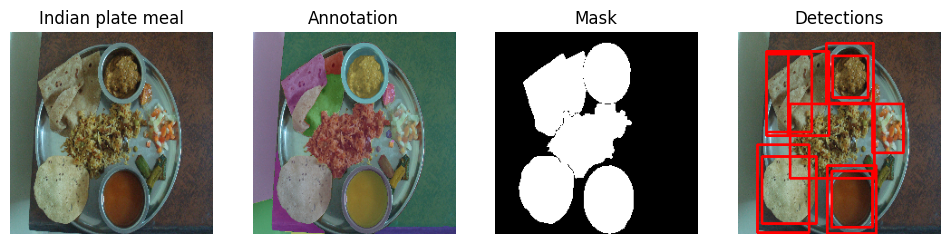

In [ ]:
image = cv2.imread(workspace + '/indian_plate_meals.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
print(image.shape)
# Display the three orthogonal slices as 2D images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
# plot the image
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Indian plate meal')
annotations = mask_generator.generate(image)
display_anns = show_anns(annotations, range(len(annotations)))
axes[1].imshow(image)
axes[1].imshow(display_anns)
axes[1].axis('off')
axes[1].set_title('Annotation')
image_mask = show_mask(annotations, [3,4,5,6,7,8,9,10])
axes[2].imshow(image_mask, cmap='gray')
axes[2].axis('off')
axes[2].set_title('Mask')
image_detections, bboxes, ROIs = show_detections(image, annotations)
axes[3].imshow(image_detections)
axes[3].axis('off')
axes[3].set_title('Detections')
fig.savefig('indian_plate_meal.jpg', format='jpg', bbox_inches='tight', pad_inches=0.05)

11


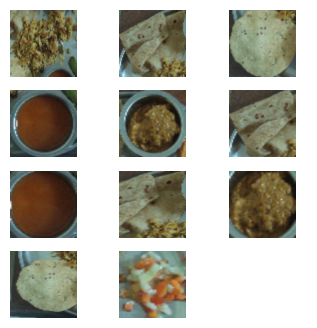

In [ ]:
# Show ROIs in a grid
import supervision as sv
print(len(ROIs))
sv.plot_images_grid(
    images=ROIs,
    grid_size=(4, int(len(ROIs)/4)+1),
    size=(4, 4)
)

In [ ]:
# ONNX model inference
import numpy as np
import onnxruntime
onnx_model_path = workspace + "/indian_food_classificaton_pytorch.onnx"

# Class names for Nutrition labeling
class_names = ['Indian bread - Naan', 'Chapati', 'Biryani', 'Uttapam', 'Paneer', 'Poha', 'Khichdi', 'Omelette',
               'Plain Rice', 'Dal Makhni', 'Dosa', 'Rajma', 'Poori', 'Chole', 'Dal', 'Sambhar', 'Papad', 'Gulab Jamun',
               'Idli', 'Vada', 'Chicken curry', 'Fish', 'potato curry', 'Okra curry', 'Green beans', 'curd']

def get_class_labels(output_probabilities, threshold=0.5):
    class_labels = []
    prediction_names = []
    for output_probs in output_probabilities:
        # Get the class index with the highest probability for each sample in the batch
        class_indices = np.argmax(output_probs, axis=1)
        # Apply a threshold if needed (e.g., for binary classification)
        if threshold is not None:
            class_indices = np.where(output_probs.max(axis=1) >= threshold, class_indices, -1)
        class_labels.extend(class_indices.tolist())
    for class_label in class_labels:
      prediction_names.append(class_names[class_label])
    return prediction_names

def run_food_classification(onnx_model_path, input_image_list):
  # Load the ONNX model
  session = onnxruntime.InferenceSession(onnx_model_path)
  # Prepare the inputs and get the names of the input and output layers
  input_names = [input.name for input in session.get_inputs()]
  output_names = [output.name for output in session.get_outputs()]

  # Initialize an empty list to store the batched output
  output_data_list = []
  batch_size = 1 # len(input_image_list)
  # Run inference for each batch of input data
  for i in range(0, len(input_image_list), batch_size):
    input_batch = input_image_list[i:i + batch_size]
    input_batch = [np.transpose(input.astype(np.float32),(2,0,1)) for input in input_batch]
    input_batch = [np.expand_dims(input,0) for input in input_batch]
    outputs = session.run(output_names, dict(zip(input_names, input_batch)))
    # Now output_data_list contains the output of each batch
    output_data_list.extend(outputs)
  # Get the class labels from the output probabilities
  predicted_labels = get_class_labels(output_data_list)

  for i in range(0, len(input_image_list), batch_size):
    image = input_image_list[i]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the three orthogonal slices as 2D images
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    # plot the image
    axes.imshow(image, cmap='gray')
    axes.axis('off')
    axes.set_title('class: {}'.format(predicted_labels[i]))
  return predicted_labels

# Get the class labels from the output probabilities
onnx_model_path = workspace + '/indian_food_classification_pytorch.onnx'
predicted_labels = run_food_classification(onnx_model_path, ROIs)
print(predicted_labels)

In [ ]:
# Show detailed masks
# import supervision as sv
# masks = [
#     mask['segmentation']
#     for mask
#     in sorted(annotations, key=lambda x: x['area'], reverse=True)
# ]

# print(len(masks))
# sv.plot_images_grid(
#     images=masks,
#     grid_size=(8, int(len(masks)/ 8)+1),
#     size=(8, 8)
# )

# print(annotations[0].keys())

In [ ]:
# sort the detections by size
annotations = sorted(annotations, key=lambda x: x['area'], reverse=True)
masks = []
bboxes = []
for annotation in annotations:
  if annotation['area'] > 20000 and annotation['area'] < 100000:
    masks.append(annotation['segmentation'])
    bboxes.append(annotation['bbox'])

# sv.plot_images_grid(
#     images=masks,
#     grid_size=(8, int(len(masks)/ 8)+1),
#     size=(8, 8)
# )

In [ ]:
ROIs = []
# Draw the bounding boxes on the image
for (x, y, w, h) in bboxes:
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    # Extract the region of interest (ROI) from the image
    roi = image[y:y+h, x:x+w]
    resized_roi = cv2.resize(roi, (256, 256))
    ROIs.append(resized_roi)

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Indian plate meal')

# Save the image with bounding boxes
cv2.imwrite('image_with_bounding_boxes.jpg', image)

In [ ]:
# display the ROIs
for i, roi in enumerate(ROIs):
  plt.figure(figsize=(10,10))
  plt.imshow(roi)
  plt.axis('off')
  plt.title('ROI: {}'.format(i))
  # Save the image with bounding boxes
  plt.savefig('ROI_{}.jpg'.format(i))
  plt.show()